In [52]:
# matplotlib inline
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from xgboost import XGBClassifier
from prettytable import PrettyTable
import scipy.stats as ss
import joblib


# 1. Data Preprocessing

<h2>1.1 Loading Dataset <h2>

In [53]:
# Read the csv file
df_train = pd.read_csv("datasets/Kaggle_Training_Dataset_v2.csv")
df_test = pd.read_csv("datasets/Kaggle_Test_Dataset_v2.csv")

In [54]:
df_train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [55]:
df_test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No


## 1.2 Dropping the last record which contains NaN

In [5]:
#Dropping last record of train and test dataset
df_train = df_train[:-1]
df_test = df_test[:-1]

# 2. Feature Engineering

## 2.1 Converting  Boolean values to Binary values 

In [6]:
# Encode categorical columns with values Yes and No to 1 and 0 respectively

#Creating dictionary with mapping values
dict_map_bool = {'Yes': 1.0, 'No': 0.0}

#Train data
df_train['deck_risk'] = df_train['deck_risk'].map(dict_map_bool)
df_train['potential_issue'] = df_train['potential_issue'].map(dict_map_bool)
df_train['oe_constraint'] = df_train['oe_constraint'].map(dict_map_bool)
df_train['ppap_risk'] = df_train['ppap_risk'].map(dict_map_bool)
df_train['stop_auto_buy'] = df_train['stop_auto_buy'].map(dict_map_bool)
df_train['rev_stop'] = df_train['rev_stop'].map(dict_map_bool)
df_train['went_on_backorder'] = df_train['went_on_backorder'].map(dict_map_bool)

#Test data
df_test['deck_risk'] = df_test['deck_risk'].map(dict_map_bool)
df_test['potential_issue'] = df_test['potential_issue'].map(dict_map_bool)
df_test['oe_constraint'] = df_test['oe_constraint'].map(dict_map_bool)
df_test['ppap_risk'] = df_test['ppap_risk'].map(dict_map_bool)
df_test['stop_auto_buy'] = df_test['stop_auto_buy'].map(dict_map_bool)
df_test['rev_stop'] = df_test['rev_stop'].map(dict_map_bool)
df_test['went_on_backorder'] = df_test['went_on_backorder'].map(dict_map_bool)

## 2.2 Replacing unknown values

In [7]:
#Replacing -99 in perfomance columns with nan

#Train data
df_train.perf_6_month_avg.replace({-99.0: np.nan}, inplace=True)
df_train.perf_12_month_avg.replace({-99.0: np.nan}, inplace=True)

#Test data
df_test.perf_6_month_avg.replace({-99.0: np.nan}, inplace=True)
df_test.perf_12_month_avg.replace({-99.0: np.nan}, inplace=True)

## 2.3 Handling missing values

In [8]:
#Using Iterative Imputer method to replace missing values

X_train_iter = df_train.copy()
X_test_iter = df_test.copy()
iter = IterativeImputer(max_iter=10, random_state=0)
iter.fit(X_train_iter)
X_train_iter[:] = iter.transform(X_train_iter)
X_test_iter[:] = iter.transform(X_test_iter)



## 2.4 Correlation of numerical features with target variable

In [9]:
#Numerical columns list
num_col_list = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month',
                'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
                'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']

In [10]:
# Correlation using Point Biserial correlation
y_train = df_train['went_on_backorder']


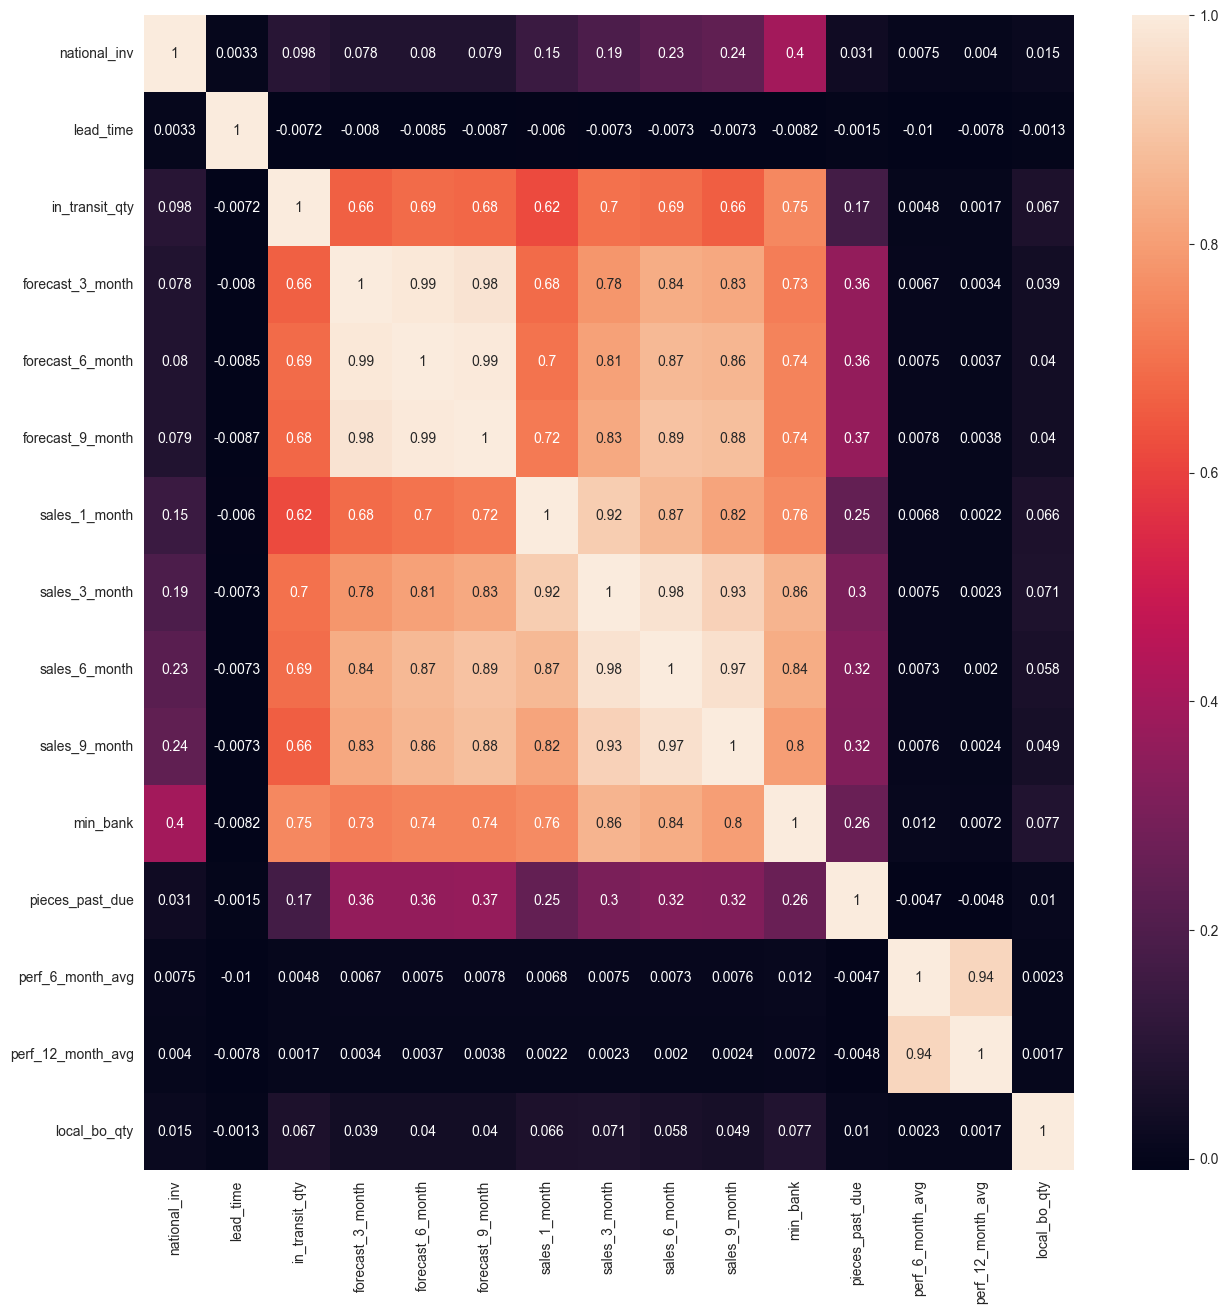

In [11]:
# Subset dataframe to only keep columns in the list
df_subset = df_train[num_col_list]

# Generate heatmap
fig, ax = plt.subplots(figsize=(15,15),facecolor='None')
sns.heatmap(df_subset.corr(),annot=True)
fig.set_facecolor('None')
plt.savefig('images/heatmap.png')
plt.show()

* perfomance columns have the highest correlation with the target variable
* Lead_time also show some correlation with the target variable
* Rest columns are not much correlated with the target variable
* local_bo_qty and pieces_past_due are the only features which are positively correlated with the target variable.


## 2.5 Raw Data features Visualization Before Transformations

In [12]:
df_train_num_untrans = df_train.copy()
df_train_num_untrans = df_train_num_untrans.drop(
    ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'], axis=1)

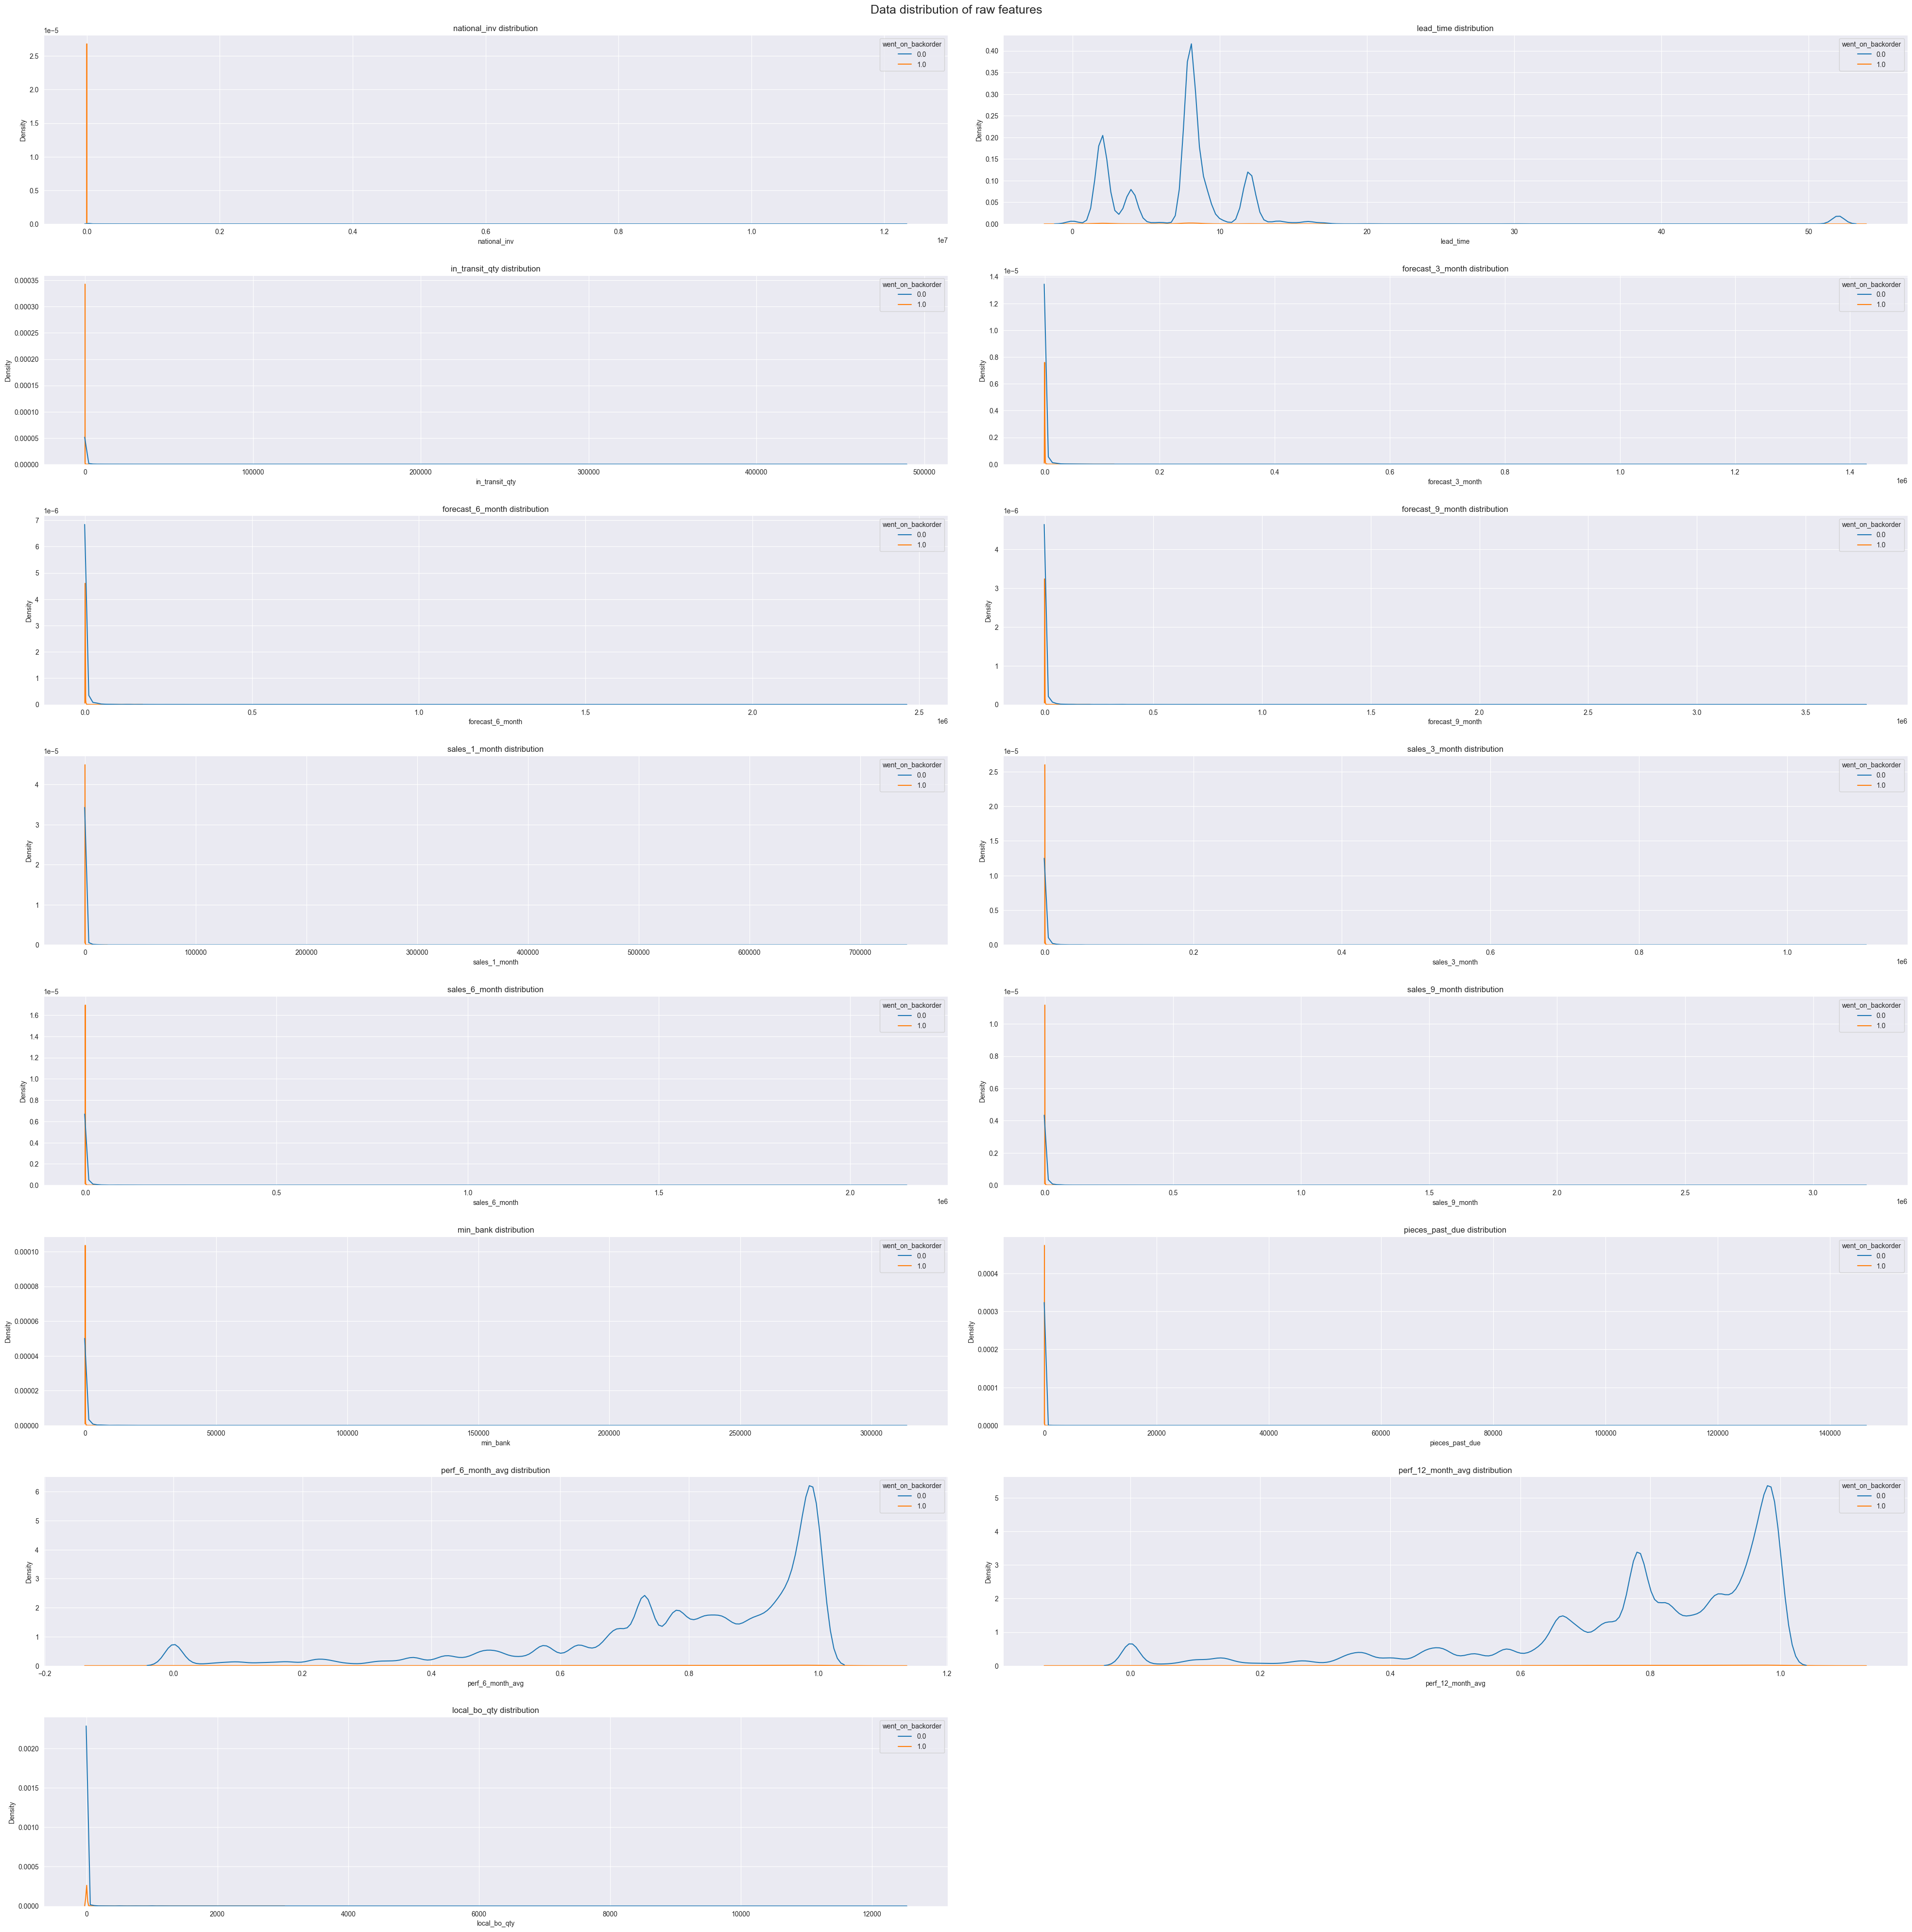

In [13]:
#Distribution of raw features before transformations
fig = plt.figure(figsize=(40, 40), facecolor='None')
for idx, val in enumerate(df_train_num_untrans.drop(['went_on_backorder'], axis=1)):
    ax1 = fig.add_subplot(8, 2, idx + 1)
    ax1.title.set_text(val + ' distribution')
    sns.kdeplot(data=df_train_num_untrans, x=val, hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Data distribution of raw features", fontsize=18, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/raw_features.png')
plt.show()

* It is difficult to seperate out the classes in these features as they are high overlapping

## 2.6 Transformed Features Visualization

In [14]:
X_train_iter_stand = X_train_iter.copy()
X_test_iter_stand = X_test_iter.copy()

In [15]:
#Applying Standard Scaler

sc = StandardScaler().fit(X_train_iter_stand[num_col_list].values)
X_tr_sc_num_feat = sc.transform(X_train_iter_stand[num_col_list].values)
X_te_sc_num_feat = sc.transform(X_test_iter_stand[num_col_list].values)

X_tr_sc_num_feat = pd.DataFrame(X_tr_sc_num_feat, index=X_train_iter_stand.index, columns=num_col_list)
X_te_sc_num_feat = pd.DataFrame(X_te_sc_num_feat, index=X_test_iter_stand.index, columns=num_col_list)

In [16]:
#Assigning numerical columns to original dataframe

for i in num_col_list:
    X_train_iter_stand[i] = X_tr_sc_num_feat[i]
    X_test_iter_stand[i] = X_te_sc_num_feat[i]

In [17]:
##Random Undersample the dataset to balance the data

undersample = RandomUnderSampler()
X_train_iter_under, y_train_iter_under = undersample.fit_resample(X_train_iter_stand, y_train)

In [18]:
#Creating undersampled dataframes for train set

X_train_iter_under = pd.DataFrame(X_train_iter_under, columns=X_train_iter_stand.columns)
y_train_iter_under = pd.DataFrame(y_train_iter_under, columns=['went_on_backorder'])

In [19]:
#Creating dataframes with numerical features for train and test set

X_train_iter_under_num = X_train_iter_under.drop(
    columns=['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'], axis=1)
X_test_iter_num = X_test_iter_stand.drop(
    columns=['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'], axis=1)

## 2.7 Creating New Transformed features

In [20]:
#Function to fit logistic regression model
def model(df_final, y):
    log_reg = LogisticRegression()
    log_reg.fit(df_final, y)
    return log_reg


#Function to perform addition of features  
def add(df, num_cols):
    for i in num_cols:
        for j in num_cols:
            if (i != j):
                df[i + '_' + j + '_add'] = df[i] + df[j]
    return df


#Function to perform multiplication of features
def mult(df, num_cols):
    for i in num_cols:
        for j in num_cols:
            if (i != j):
                df[i + '_' + j + '_mult'] = df[i] * df[j]
    return df


#Function to perform inverse of features
def inv(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'inv'] = 1 / (df[i] + 0.001)

    return df


#Function to perform square of features
def square(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'square'] = df[i] * df[i]
    return df


#Function to perform square root of features
def sqrt(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'square_root'] = np.sqrt(abs(df[i]))
    return df


#Function to perform log of features
def log(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'log'] = (np.log(abs(df[i]) + 1))
    return df

In [21]:
#Applying tranformed functions on train data
X_train_iter_trans = add(X_train_iter_under_num, num_col_list)
X_train_iter_trans = mult(X_train_iter_trans, num_col_list)
X_train_iter_trans = inv(X_train_iter_trans, num_col_list)
X_train_iter_trans = square(X_train_iter_trans, num_col_list)
X_train_iter_trans = sqrt(X_train_iter_trans, num_col_list)
X_train_iter_trans = log(X_train_iter_trans, num_col_list)

#Applying tranformed functions on test data
X_test_iter_trans = add(X_test_iter_num, num_col_list)
X_test_iter_trans = mult(X_test_iter_trans, num_col_list)
X_test_iter_trans = inv(X_test_iter_trans, num_col_list)
X_test_iter_trans = square(X_test_iter_trans, num_col_list)
X_test_iter_trans = sqrt(X_test_iter_trans, num_col_list)
X_test_iter_trans = log(X_test_iter_trans, num_col_list)



In [22]:
y_train_iter_trans = X_train_iter_trans['went_on_backorder'].values
y_test_iter_trans = X_test_iter_trans['went_on_backorder'].values

X_train_iter_trans = X_train_iter_trans.drop(['went_on_backorder'], axis=1)
X_test_iter_trans = X_test_iter_trans.drop(['went_on_backorder'], axis=1)

#applying logistic regression
model = model(X_train_iter_trans, y_train_iter_trans)
importances = model.coef_
abs_imp = np.abs(importances[0])

#get the sorting indices
sorted_idx = (-abs_imp).argsort()

In [23]:
#print top 20 most important columns
for i in sorted_idx[:20]:
    print(X_train_iter_trans.columns[i])

local_bo_qty_inv
lead_time_inv
local_bo_qty_square
in_transit_qty_inv
pieces_past_due_inv
perf_6_month_avg_inv
perf_6_month_avg_square
perf_12_month_avg_square
perf_6_month_avg_perf_12_month_avg_mult
perf_12_month_avg_perf_6_month_avg_mult
national_inv_square
perf_12_month_avg_perf_6_month_avg_add
perf_6_month_avg_perf_12_month_avg_add
perf_12_month_avg_lead_time_add
lead_time_perf_12_month_avg_add
perf_6_month_avg_lead_time_add
lead_time_perf_6_month_avg_add
min_bank_inv
lead_time_square
national_inv_perf_12_month_avg_add


In [24]:
X_train_iter_trans_plt = X_train_iter_trans.copy()
X_train_iter_trans_plt['went_on_backorder'] = y_train_iter_trans

### 2.8 Plot of original and transformed features

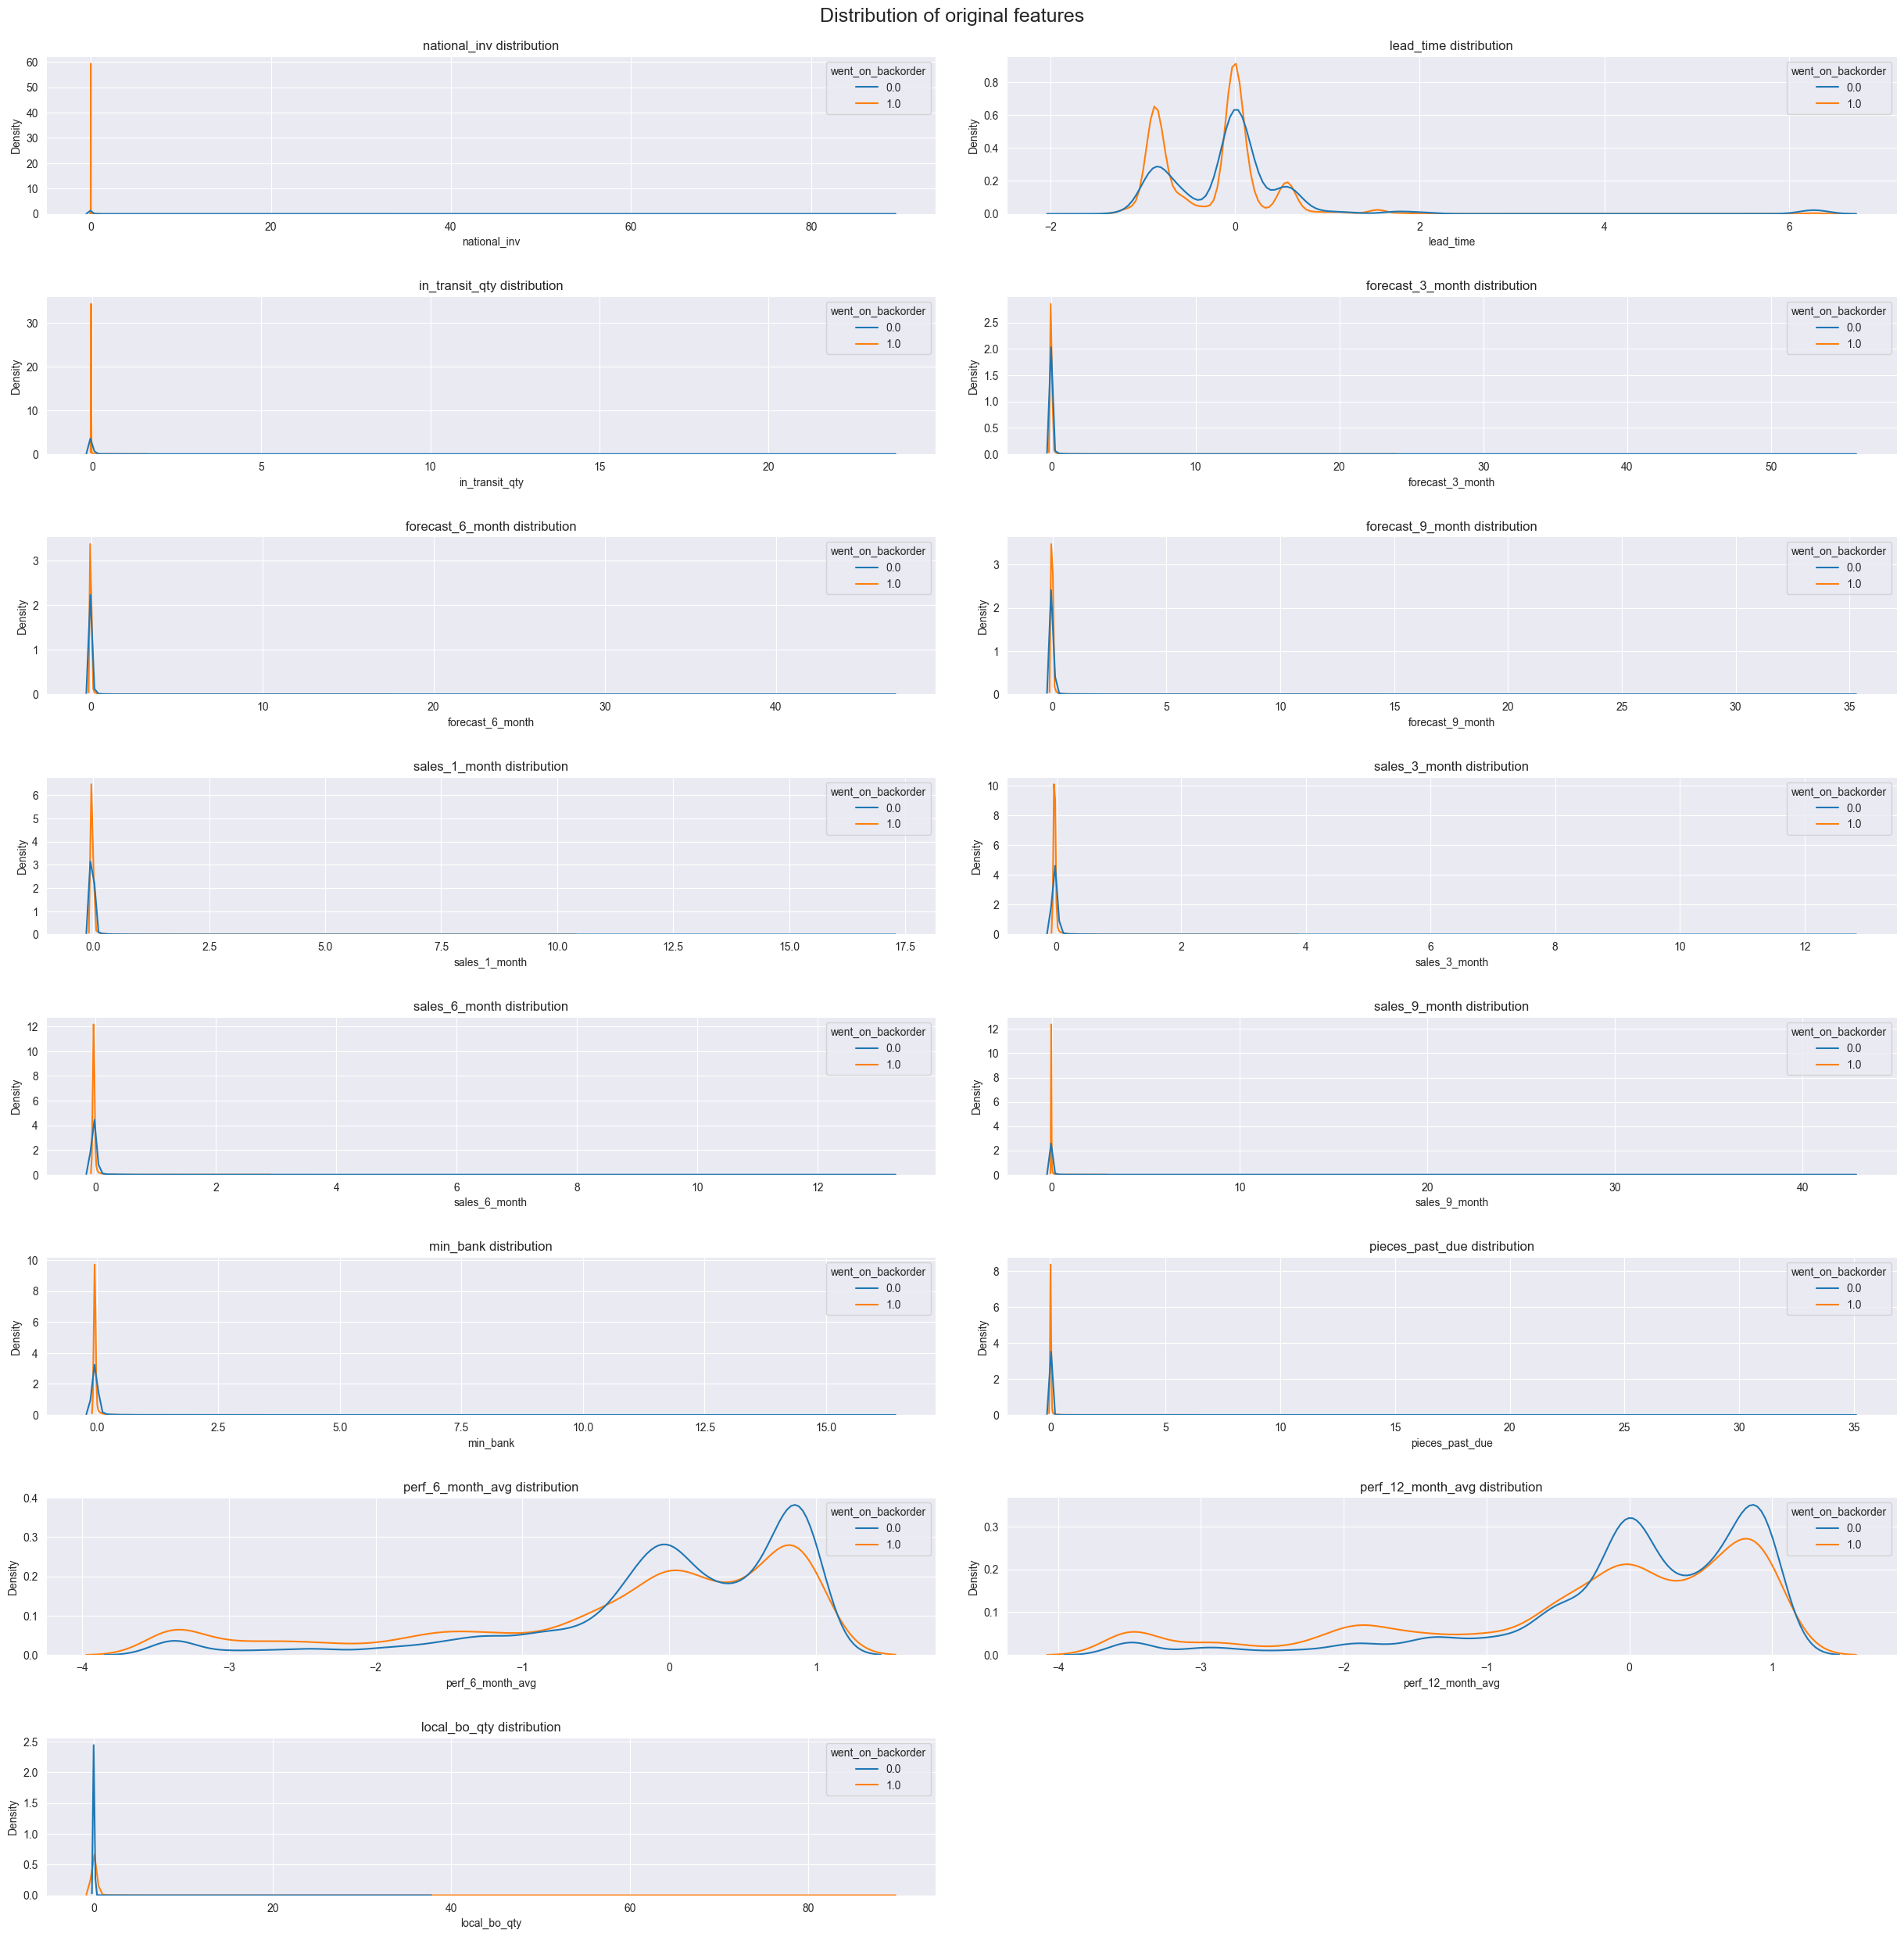

In [25]:
#Distribution of original features

fig = plt.figure(figsize=(25, 25))
for i, j in enumerate(num_col_list):
    ax1 = fig.add_subplot(8, 2, i + 1)
    p = X_train_iter_trans[j]
    ax1.title.set_text(j + ' distribution')
    sns.kdeplot(data=X_train_iter_trans_plt, x=num_col_list[i], hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of original features", fontsize=18, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/original_after_trans.png')
plt.show()

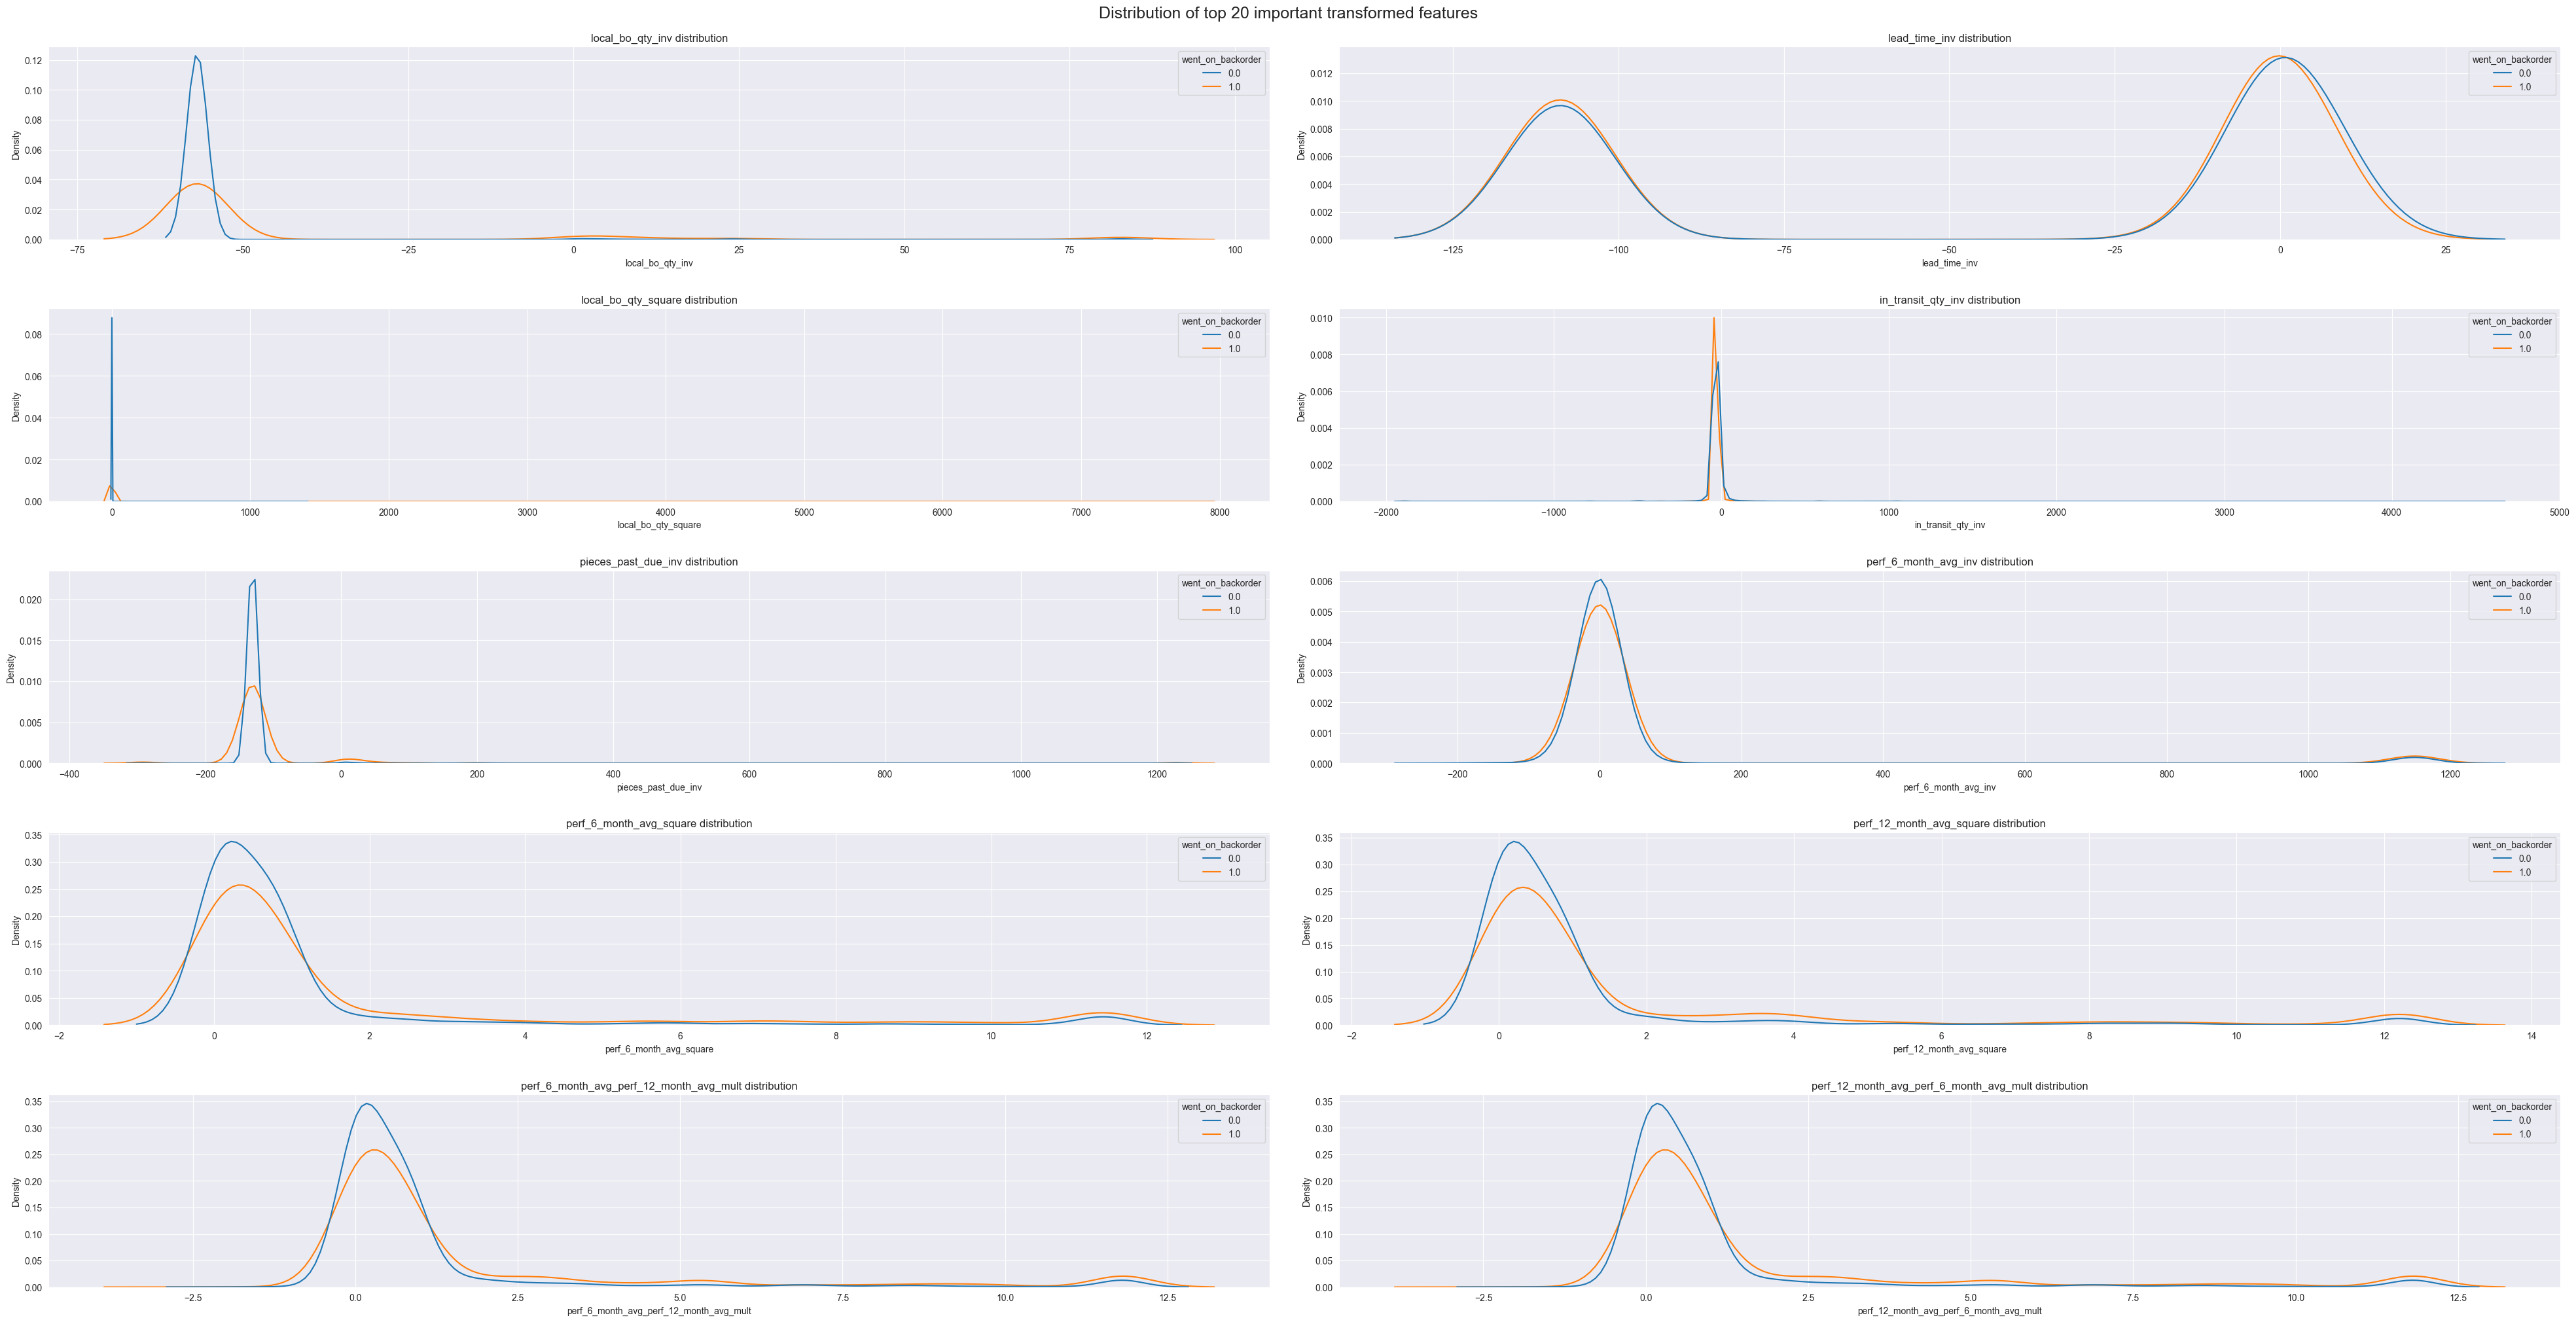

In [26]:
#Distribution of  newly created tranformed features

fig = plt.figure(figsize=(40, 40))
for i, j in enumerate(sorted_idx[:10]):
    ax1 = fig.add_subplot(10, 2, i + 1)
    ax1.title.set_text(X_train_iter_trans_plt.columns[j] + ' distribution')
    sns.kdeplot(data=X_train_iter_trans_plt, x=X_train_iter_trans_plt.columns[j], hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of top 20 important transformed features", fontsize=18, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/top_features.png')
plt.show()



* These newly created features are less skewed and  we are able to see some seperation between positve and negative points which will be helpful in classification

## 2.9 Selecting best features based on Recursive Feature Selection

In [27]:
#Assigning remaning columns to train and test data

for cols in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']:
    X_train_iter_trans[cols] = X_train_iter_under[cols]
    X_test_iter_trans[cols] = X_test_iter_stand[cols]


In [28]:
def best_feat(X_train, X_test, y_train, y_test, num_folds=4):
    roc_score = 1
    imp_cols = set()
    train_data = X_train
    target_train_data = y_train
    test_data = X_test
    target_test_data = y_test
    cols_list = list(train_data.columns)
    imp_cols_list = list(imp_cols)
    iter = 1

    while (roc_score > 0.8) & (len(imp_cols_list) != len(cols_list)):

        #Performing K-folds split
        train_data_rem = train_data[train_data.columns[~train_data.columns.isin(imp_cols_list)]]
        Kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=33)
        splits = Kfold.split(train_data_rem, target_train_data)
        model_feature_importance = np.zeros_like(train_data_rem.columns)
        roc_scores = []

        print("\nIteration -", iter)
        print('*********************')

        #Performing K-Fold Cross validation
        for fold_num, (train_idx, val_idx) in enumerate(splits, 1):
            print("Fold-", fold_num)

            #defining the train and validation data
            x_train = train_data_rem.iloc[train_idx]
            x_val = train_data_rem.iloc[val_idx]
            y_train = target_train_data.iloc[train_idx]
            y_val = target_train_data.iloc[val_idx]

            #Implementing the XGB Classifier
            xg = XGBClassifier(n_jobs=-1, random_state=33)
            xg.fit(x_train, y_train)

            #Adding the feature importance of each feature averaged over different folds
            model_feature_importance += (xg.feature_importances_)

            #ROC-AUC Score for each K-fold
            roc = roc_auc_score(y_val, xg.predict_proba(x_val)[:, 1])
            print("ROC score at the end of Fold-{} is {}".format(fold_num, roc))
            roc_scores.append(roc)

        #Mean of the scores over K-folds
        roc_score = mean(roc_scores)
        print('\n\nROC score at the end of iteration {} is {}'.format(iter, roc_score))

        #Average feature importances
        model_feature_importance = model_feature_importance / num_folds

        #getting the non-zero feature important indices
        imp_cols_idx = np.where(np.abs(model_feature_importance) > 0)

        #getting the non-zero feature important column names
        imp_cols_names = x_train.columns[imp_cols_idx]

        print("")

        #Appending important columns at each iteration
        if roc_score > 0.8:
            imp_cols.update(imp_cols_names)

        imp_cols_list = list(imp_cols)

        print("Number of features at the end of iteration {} is {}\n\n".format(iter, len(imp_cols_list)))
        iter += 1

    #Storing train and test data
    train_data = train_data[imp_cols_list]
    test_data = test_data[imp_cols_list]

    return train_data, test_data


In [29]:
#Creating dataframe for target variable
y_train = pd.DataFrame(y_train_iter_trans, columns=['went_on_backorder'])
y_test = pd.DataFrame(y_test_iter_trans, columns=['went_on_backorder'])

x_train, x_test = best_feat(X_train_iter_trans, X_test_iter_trans, y_train, y_test, 4)


Iteration - 1
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.96337588646077
Fold- 2
ROC score at the end of Fold-2 is 0.9611412326307877
Fold- 3
ROC score at the end of Fold-3 is 0.9659821422857559
Fold- 4
ROC score at the end of Fold-4 is 0.9632671081843904


ROC score at the end of iteration 1 is 0.963441592390426

Number of features at the end of iteration 1 is 256



Iteration - 2
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.9640878648575691
Fold- 2
ROC score at the end of Fold-2 is 0.9619212604074785
Fold- 3
ROC score at the end of Fold-3 is 0.9646824092718471
Fold- 4
ROC score at the end of Fold-4 is 0.961663836440935


ROC score at the end of iteration 2 is 0.9630888427444575

Number of features at the end of iteration 2 is 481



Iteration - 3
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.9566579387849103
Fold- 2
ROC score at the end of Fold-2 is 0.9565295543787926
Fold- 3
ROC score at the end of Fold-3 is 0.957650073

# 3. Training Model

## 3.1 Train-Test Split

In [30]:
#Stratify split of train data
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.10)

## 3.4 Decision Tree

In [31]:
#Define the grid search parameters
dt = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15]}
clf = GridSearchCV(dt, parameters, scoring='f1')
gs = clf.fit(x_train, y_train)
print("Best Params : ", gs.best_params_)
print("Best Score : ", gs.best_score_)

Best Params :  {'criterion': 'gini', 'max_depth': 12}
Best Score :  0.8771504286853167


In [32]:
from sklearn.metrics import accuracy_score

#Training on best parameters
dt = DecisionTreeClassifier(criterion=gs.best_params_['criterion'], max_depth=gs.best_params_['max_depth'])
dt.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr = dt.predict(x_train)
y_prob_tr = dt.predict_proba(x_train)[:, 1]

y_pred_cv = dt.predict(x_cv)
y_prob_cv = dt.predict_proba(x_cv)[:, 1]

y_pred_test = dt.predict(x_test)
y_prob_test = dt.predict_proba(x_test)[:, 1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_tr), 4)
        rs = round(recall_score(y_train, y_pred_tr), 4)
        ps = round(average_precision_score(y_train, y_prob_tr), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_cv), 4)
        rs = round(recall_score(y_cv, y_pred_cv), 4)
        ps = round(average_precision_score(y_cv, y_prob_cv), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])

print('\n')
print(x)



+----------+---------------+----------+--------+-----------+
| Data Set |     Model     | Accuracy | Recall | Precision |
+----------+---------------+----------+--------+-----------+
|  Train   | Decision Tree |  0.9504  | 0.9588 |   0.9816  |
|    CV    | Decision Tree |  0.8862  | 0.8999 |   0.8525  |
|   Test   | Decision Tree |  0.873   | 0.7783 |   0.0524  |
+----------+---------------+----------+--------+-----------+


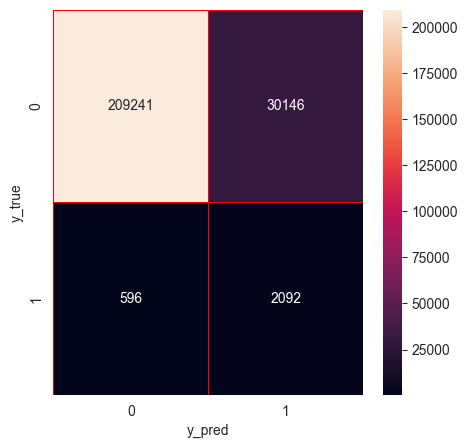

In [33]:
#Plot confusion matrix for test data

y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## 3.5 Random Forest

In [34]:
#Define the grid search parameters
rf = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 20, 30, 40, 50, 70, 90, 120]}
clf = GridSearchCV(rf, parameters, scoring='f1')
gs = clf.fit(x_train, y_train)
print("Best Params : ", gs.best_params_)
print("Best Score : ", gs.best_score_)

Best Params :  {'max_depth': 40, 'n_estimators': 200}
Best Score :  0.9173139177960122


In [35]:
#Training on best parameters
rf = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], max_depth=gs.best_params_['max_depth'])
rf.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr = rf.predict(x_train)
y_prob_tr = rf.predict_proba(x_train)[:, 1]

y_pred_cv = rf.predict(x_cv)
y_prob_cv = rf.predict_proba(x_cv)[:, 1]

y_pred_test = rf.predict(x_test)
y_prob_test = rf.predict_proba(x_test)[:, 1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_tr), 4)
        rs = round(recall_score(y_train, y_pred_tr), 4)
        ps = round(average_precision_score(y_train, y_prob_tr), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_cv), 4)
        rs = round(recall_score(y_cv, y_pred_cv), 4)
        ps = round(average_precision_score(y_cv, y_prob_cv), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])

print(x)



+----------+---------------+----------+--------+-----------+
| Data Set |     Model     | Accuracy | Recall | Precision |
+----------+---------------+----------+--------+-----------+
|  Train   | Random Forest |  0.9982  | 0.9986 |   0.9999  |
|    CV    | Random Forest |  0.9146  | 0.9469 |   0.9572  |
|   Test   | Random Forest |  0.8987  | 0.7987 |   0.1773  |
+----------+---------------+----------+--------+-----------+


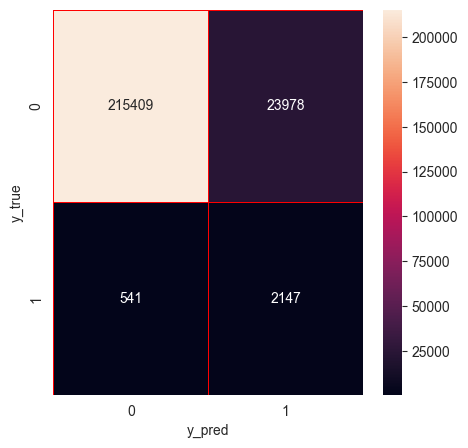

In [36]:
#Plot confusion matrix for test data

y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## 3.7 Light GBM

In [37]:
#Define the grid search parameters
lgbm = LGBMClassifier()
parameters = {'n_estimators': [10, 100, 200, 500], 'max_depth': [5, 7, 10, 20, 30, 50]}
clf = GridSearchCV(lgbm, parameters, n_jobs=-1, scoring='f1')
gs = clf.fit(x_train, y_train)
print("Best Params : ", gs.best_params_)
print("Best Score : ", gs.best_score_)

/Volumes/proj/adm/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Volumes/proj/adm/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Volumes/proj/adm/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Volumes/proj/adm/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed 

Best Params :  {'max_depth': 20, 'n_estimators': 500}
Best Score :  0.9202584658622127


In [38]:
from sklearn.metrics import accuracy_score

#Training on best parameters
lgbm = LGBMClassifier(n_estimators=gs.best_params_['n_estimators'], max_depth=gs.best_params_['max_depth'], n_jobs=-1)
lgbm.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr = lgbm.predict(x_train)
y_prob_tr = lgbm.predict_proba(x_train)[:, 1]

y_pred_cv = lgbm.predict(x_cv)
y_prob_cv = lgbm.predict_proba(x_cv)[:, 1]

y_pred_test = lgbm.predict(x_test)
y_prob_test = lgbm.predict_proba(x_test)[:, 1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_tr), 4)
        rs = round(recall_score(y_train, y_pred_tr), 4)
        ps = round(average_precision_score(y_train, y_prob_tr), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_cv), 4)
        rs = round(recall_score(y_cv, y_pred_cv), 4)
        ps = round(average_precision_score(y_cv, y_prob_cv), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])

print('\n')
print(x)



+----------+-----------+----------+--------+-----------+
| Data Set |   Model   | Accuracy | Recall | Precision |
+----------+-----------+----------+--------+-----------+
|  Train   | Light GBM |  0.9952  | 0.997  |   0.9998  |
|    CV    | Light GBM |  0.9199  | 0.9486 |   0.9639  |
|   Test   | Light GBM |  0.908   | 0.7853 |   0.202   |
+----------+-----------+----------+--------+-----------+


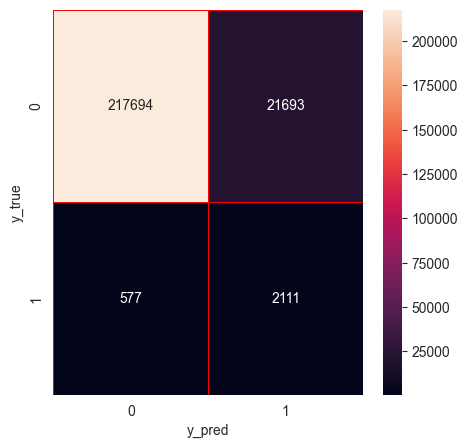

In [39]:
#Plot confusion matrix for test data

y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## 3.8 Saving the best performed model and features

In [56]:
#Saving the test data
x_test.to_csv('datasets/Test_dataset.csv')


In [59]:
testing = pd.read_csv('datasets/Test_dataset.csv')
testing.drop(['Unnamed: 0'], axis=1, inplace=True)

[[0.99651713 0.00348287]]


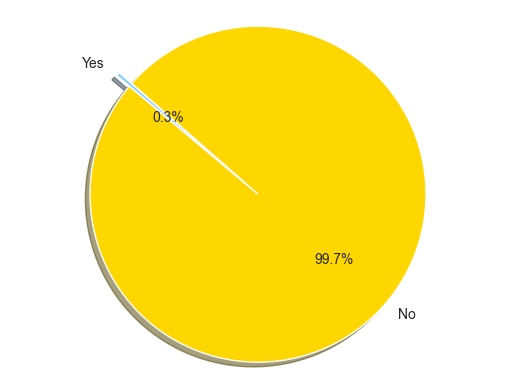

In [60]:
# Creating a Pie Chart

def piechart(df):
    new = df[5:6:]

    filename = 'backorder_best_model.pkl'
    model = joblib.load(filename)
    predictions = model.predict_proba(new)
    arr = np.array(predictions)
    print(predictions)

    labels = ['No', 'Yes']
    colors = ['#FFC107', '#03A9F4']  # custom colors for the pie chart
    colors = ['gold', 'lightskyblue']
    explode = (0.1, 0)  # explode 1st slice

    fig, ax = plt.subplots(facecolor='None')
    ax.pie(arr[0], explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')

    fig.set_facecolor('None')
    plt.savefig(
        'images/piechart.png')  # save the figure with no padding and no background
    plt.show()


piechart(testing)


In [61]:
testing = pd.concat([testing, y_test], axis=1)
testing

,forecast_6_month_in_transit_qty_add,perf_12_month_avg_sales_1_month_add,forecast_6_month_perf_6_month_avg_add,sales_6_month_sales_1_month_mult,sales_1_month_in_transit_qty_add,stop_auto_buy,in_transit_qty_lead_time_mult,perf_6_month_avg_sales_1_month_add,perf_6_month_avg_sales_6_month_add,national_inv_sales_6_month_mult,...,sales_9_month_national_inv_add,forecast_9_month_sales_3_month_mult,forecast_6_month_forecast_3_month_mult,national_inv_forecast_3_month_mult,sales_1_month_pieces_past_due_mult,sales_3_month_sales_9_month_mult,forecast_9_month_perf_12_month_avg_add,forecast_6_month_national_inv_mult,in_transit_qty_perf_12_month_avg_add,went_on_backorder
0,-0.068028,-0.047725,-0.060839,0.001031,-0.061812,1.0,-0.004705,-0.054623,-0.061167,0.000521,...,-0.050057,0.001187,0.001248,0.000519,0.000251,0.001193,-0.053936,0.000516,-0.051528,0.0
1,-0.068028,-0.163259,-0.182814,0.001031,-0.061812,0.0,-0.058059,-0.176598,-0.183142,0.000585,...,-0.051847,0.001187,0.001248,0.000583,0.000251,0.001193,-0.169471,0.000579,-0.167063,0.0
2,-0.068028,0.753263,0.572073,0.001031,-0.061812,1.0,0.000334,0.578289,0.571745,0.000575,...,-0.051577,0.001187,0.001248,0.000573,0.000251,0.001193,0.747051,0.000570,0.749459,0.0
3,-0.068028,-0.147484,-0.035350,0.001031,-0.061812,1.0,0.028416,-0.029134,-0.035678,0.000585,...,-0.051712,0.001187,0.001248,0.000583,0.000251,0.001189,-0.153695,0.000579,-0.151287,0.0
4,-0.068028,-0.327633,-1.076648,0.001031,-0.061812,1.0,0.000334,-1.070432,-1.076976,0.000593,...,-0.052083,0.001187,0.001248,0.000591,0.000251,0.001193,-0.333844,0.000588,-0.331436,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242070,-0.068028,-1.363491,-1.336972,0.001031,-0.061812,1.0,-0.018387,-1.330756,-1.337300,0.000581,...,-0.051746,0.001187,0.001248,0.000579,0.000251,0.001193,-1.369703,0.000576,-1.367295,0.0
242071,-0.068028,-1.363491,-1.336972,0.001031,-0.061812,1.0,-0.018387,-1.330756,-1.337300,0.000580,...,-0.051712,0.001187,0.001248,0.000578,0.000251,0.001193,-1.369703,0.000575,-1.367295,0.0
242072,-0.068028,-1.363491,-1.336972,0.001031,-0.061812,1.0,-0.018387,-1.330756,-1.337300,0.000580,...,-0.051712,0.001187,0.001248,0.000578,0.000251,0.001193,-1.369703,0.000575,-1.367295,0.0
242073,-0.068028,-1.363491,-1.336972,0.001031,-0.061812,1.0,-0.018387,-1.330756,-1.337300,0.000583,...,-0.051813,0.001187,0.001248,0.000582,0.000251,0.001193,-1.369703,0.000578,-1.367295,0.0


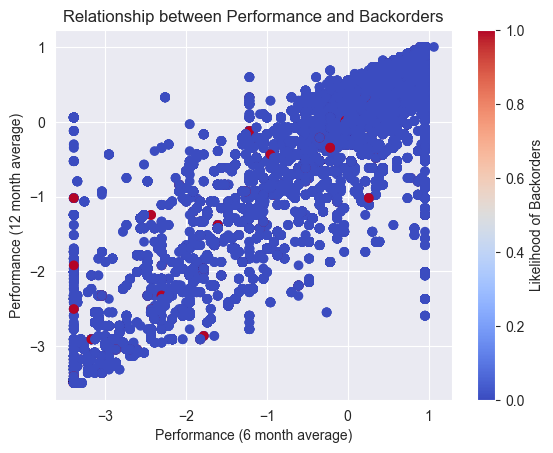

In [65]:
#Performance chart

import matplotlib.pyplot as plt

data = testing.copy()
fig, ax = plt.subplots(facecolor='None')
plt.scatter(data['perf_6_month_avg'], data['perf_12_month_avg'], c=data['went_on_backorder'], cmap='coolwarm')
plt.xlabel('Performance (6 month average)')
plt.ylabel('Performance (12 month average)')
plt.title('Relationship between Performance and Backorders')
plt.colorbar(label='Likelihood of Backorders')
fig.set_facecolor('None')  # set the background color of the figure to None
plt.savefig('images/performance.png')  # save the figure with no padding
plt.show()



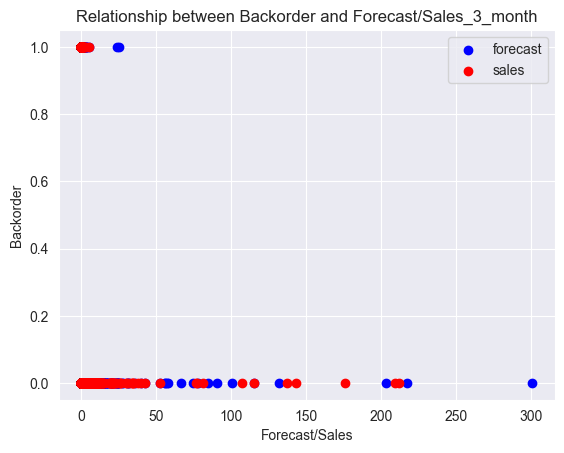

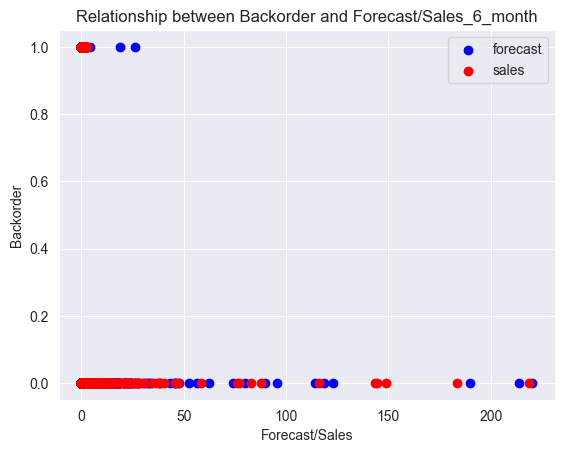

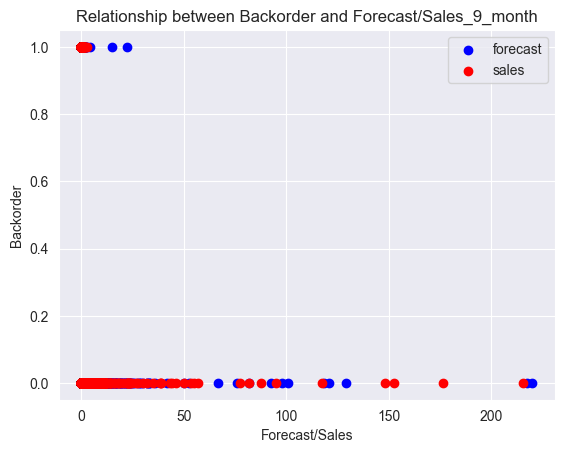

In [66]:
#Forecast and Sales chart
import matplotlib.pyplot as plt


def forecast_sales(data, forcast, sales):
    for i in range(len(sales)):
        fig, ax = plt.subplots(facecolor='None')

        # create a scatter plot of forecast vs. backorders
        plt.scatter(data[forcast[i]], data['went_on_backorder'], color='blue', label='forecast')

        # create a scatter plot of sales vs. backorders
        plt.scatter(data[sales[i]], data['went_on_backorder'], color='red', label='sales')

        # set axis labels and title
        plt.xlabel('Forecast/Sales')
        plt.ylabel('Backorder')
        plt.title('Relationship between Backorder and Forecast/Sales' + sales[i][5:])

        # show the legend
        plt.legend()

        # display the plot 
        fig.set_facecolor('None')
        plt.savefig('images/' + sales[i][5:] + 'sales.png')  # save the figure with no padding and no background
        plt.show()


forcast_col = ['forecast_3_month', 'forecast_6_month', 'forecast_9_month']
sales_col = ['sales_3_month', 'sales_6_month', 'sales_9_month']
forecast_sales(testing, forcast_col, sales_col)